# Airbnb Price Prediction

## Data preprocessing

### Exploring the data

In [237]:
# Imports

import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
import itertools

In [238]:
# Importing the training data

data = pd.read_csv('../../data/train_airbnb_berlin.csv', delimiter = ',')
data.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,...,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,...,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,...,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


In [240]:
# Important preprocessing: replacing all '*' strings by NaNs

data[data == '*'] = np.nan

In [241]:
# Global overview of the data

print(data.shape)
data.describe()

(15692, 39)


,Listing ID,Host ID,Latitude,Longitude,Square Feet,Reviews,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price
count,1.569100e+04,1.569200e+04,15692.000000,15692.000000,303.000000,15692.000000,12730.000000,12721.000000,12722.000000,12719.000000,12722.000000,12721.000000,12720.000000,15683.000000
mean,1.780062e+07,6.119042e+07,52.509893,13.407334,445.900990,19.452014,94.717282,9.717475,9.328407,9.769164,9.779201,9.556874,9.458097,60.342983
std,9.952544e+06,6.739421e+07,0.031286,0.058646,414.817342,39.483853,7.069787,0.671793,1.023807,0.620347,0.619545,0.731109,0.788891,48.829687
min,2.241500e+04,1.101500e+04,52.369270,13.121400,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000
25%,9.052831e+06,9.274528e+06,52.488920,13.376025,0.000000,1.000000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,32.000000
50%,1.865037e+07,3.358182e+07,52.509100,13.417250,440.000000,5.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,49.000000
75%,2.611308e+07,9.325677e+07,52.532713,13.439750,700.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,70.000000
max,3.467450e+07,2.609698e+08,52.639670,13.709020,1912.000000,424.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,900.000000


In [242]:
# Exploring the features with less than 200 DISTINCT values

for feature in data.columns.tolist():
    unique_list = data[feature].unique().tolist()
    if len(unique_list) < 200:
        print(f'{feature} (n = {len(unique_list)}): \n{unique_list}\n')

Listing Name (n = 1): 
[nan]

Host Response Time (n = 5): 
[nan, 'within a few hours', 'within an hour', 'within a day', 'a few days or more']

Host Response Rate (n = 34): 
[nan, '92%', '100%', '80%', '71%', '83%', '98%', '78%', '89%', '50%', '90%', '70%', '20%', '97%', '91%', '88%', '75%', '93%', '0%', '67%', '33%', '40%', '58%', '86%', '60%', '95%', '94%', '96%', '82%', '63%', '99%', '87%', '25%', '30%']

Is Superhost (n = 3): 
['f', 't', nan]

neighbourhood (n = 63): 
['Prenzlauer Berg', 'Pankow', 'Friedrichshain', 'Mariendorf', 'Wilmersdorf', 'Kreuzberg', 'Moabit', 'NeukÃ¶lln', 'Alt-Treptow', 'SchÃ¶neberg', 'Reinickendorf', 'Mitte', 'Karlshorst', 'WeiÃ\x9fensee', 'Friedenau', 'Hansaviertel', 'Wedding', 'Charlottenburg', 'Steglitz', 'Baumschulenweg', 'Alt-HohenschÃ¶nhausen', 'Rummelsburg', 'Lichterfelde', 'OberschÃ¶neweide', 'Britz', 'Lichtenberg', 'Grunewald', 'Altglienicke', 'Westend', 'Tempelhof', 'Marzahn', 'Mahlsdorf', 'Adlershof', 'NiederschÃ¶nhausen', 'Tegel', 'Rahnsdorf', '

In [243]:
# Checking the proportion of missing values for each feature

data.isnull().sum()/data.shape[0]

Listing ID               0.000064
Listing Name             1.000000
Host ID                  0.000000
Host Name                0.001402
Host Since               0.001338
Host Response Time       0.450867
Host Response Rate       0.461955
Is Superhost             0.001466
neighbourhood            0.012937
Neighborhood Group       0.000000
City                     0.003059
Postal Code              0.070036
Country Code             0.000000
Country                  0.000000
Latitude                 0.000000
Longitude                0.000000
Is Exact Location        0.000000
Property Type            0.004780
Room Type                0.000000
Accomodates              0.001211
Bathrooms                0.001593
Bedrooms                 0.001020
Beds                     0.001275
Square Feet              0.980691
Guests Included          0.000637
Min Nights               0.015868
Reviews                  0.000000
First Review             0.172381
Last Review              0.172445
Overall Rating

The preprocessing of the data will be done in two phases: the first one, the preliminary data preprocessing, will be common to all Machine Learning approaches that will be used in this project. Since different approaches require different preprocessings, the second phase will be specific to each one.

### Preliminary data preprocessing

In [244]:
few_missing = data[["Host Since",
                    "Is Superhost",
                    "Property Type",
                    "Accomodates",
                    "Bathrooms",
                    "Bedrooms",
                    "Beds",
                    "Guests Included",
                    "Min Nights",
                    "Price"]].isnull().sum()

print(f"Missing values per feature:\n\n{few_missing}\n")

# Proportion of instances with missing values in the aforementioned features

few_missing_prop = few_missing.sum()/data.shape[0]

print(f"Proportion of instances with missing values in the aforementioned features:\n\n{few_missing_prop}")

Missing values per feature:

Host Since          21
Is Superhost        23
Property Type       75
Accomodates         19
Bathrooms           25
Bedrooms            16
Beds                20
Guests Included     10
Min Nights         249
Price                9
dtype: int64

Proportion of instances with missing values in the aforementioned features:

0.02976038745857762


The instances with missing values in the aforementioned attributes represent merely 3% of the entire dataset (as given above by *few_missing_prop*). We can therefore reasonably assume they are Missing Completely At Random (MCAR), which allows us to perform listwise deletion.

In [245]:
def preliminary_preprocessing(data):

    # We remove all features that are deemed irrelevant for the price prediction

    data_clean = data.drop(["Host Name",
                            "Host ID",
                            "Listing ID",
                            "Listing Name",
                            "neighbourhood",
                            "City",
                            "Country Code",
                            "Country",
                            "Postal Code",
                            "Square Feet", 
                            "First Review",
                            "Last Review",
                            "Business Travel Ready"], axis=1)

    # Removing instances with NaNs in the aforementioned features 

    data_clean = data_clean.dropna(subset=["Host Since",
                                           "Is Superhost",
                                           "Property Type",
                                           "Accomodates",
                                           "Bathrooms",
                                           "Bedrooms",
                                           "Beds",
                                           "Guests Included",
                                           "Min Nights",
                                           "Price"])

    # Let's fill NaN values by "unknown" where we can

    data_clean = data_clean.replace({"Host Response Time": np.nan}, "unknown")

    # Replacing binary values by 0 and 1

    data_clean = data_clean.replace({"Is Superhost": "t"}, 1)
    data_clean = data_clean.replace({"Is Superhost": "f"}, 0)
    data_clean["Is Superhost"] = data_clean["Is Superhost"].astype(float)    

    data_clean = data_clean.replace({"Is Exact Location": "t"}, 1)
    data_clean = data_clean.replace({"Is Exact Location": "f"}, 0)
    data_clean["Is Exact Location"] = data_clean["Is Exact Location"].astype(float)

    data_clean = data_clean.replace({"Instant Bookable": "t"}, 1)
    data_clean = data_clean.replace({"Instant Bookable": "f"}, 0)
    data_clean["Instant Bookable"] = data_clean["Instant Bookable"].astype(float)

    # Converting certain numeric features into floats (they were strings)

    data_clean["Accomodates"] = data_clean["Accomodates"].astype(float)
    data_clean["Bathrooms"] = data_clean["Bathrooms"].astype(float)
    data_clean["Bedrooms"] = data_clean["Bedrooms"].astype(float)      
    data_clean["Beds"] = data_clean["Beds"].astype(float)          
    data_clean["Guests Included"] = data_clean["Guests Included"].astype(float)
    data_clean["Min Nights"] = data_clean["Min Nights"].astype(float)

    # String to float for 'Host Response Rate' (removing the '%')

    data_clean["Host Response Rate"] = data_clean["Host Response Rate"].str.rstrip("%").astype(float)

    # Changing host since into continous form

    data_clean["Host Since"] = pd.to_datetime(data_clean["Host Since"])
    most_recent =  max(data_clean["Host Since"])
    seniority = [(most_recent-x).days for x in data_clean["Host Since"]]
    data_clean["Host Since"] = seniority

    # One-hot encoding for categorical values

    dummies_response_time  = pd.get_dummies(data_clean[["Host Response Time"]])
    dummies_property_type = pd.get_dummies(data_clean[["Property Type"]])
    dummies_room_type = pd.get_dummies(data_clean[["Room Type"]])

    X_ = data_clean.drop(["Host Response Time", "Property Type", "Room Type"], axis=1)
    data_clean_final = pd.concat([X_, dummies_response_time, dummies_property_type, dummies_room_type], axis=1)
    
    return data_clean_final

**Nota Bene:** Since "Host Response Time" is an **ordinal** categorical feature, we would have liked to encode it with numeric values (e.g., "within an hour" = 1, "within a few hours" = 2, so that "within an hour" < "within a few hours", and so on), but because of the missing values, we had to one-hot encode it.

In [246]:
data_clean = preliminary_preprocessing(data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faad5328f98>,
      dtype=object)

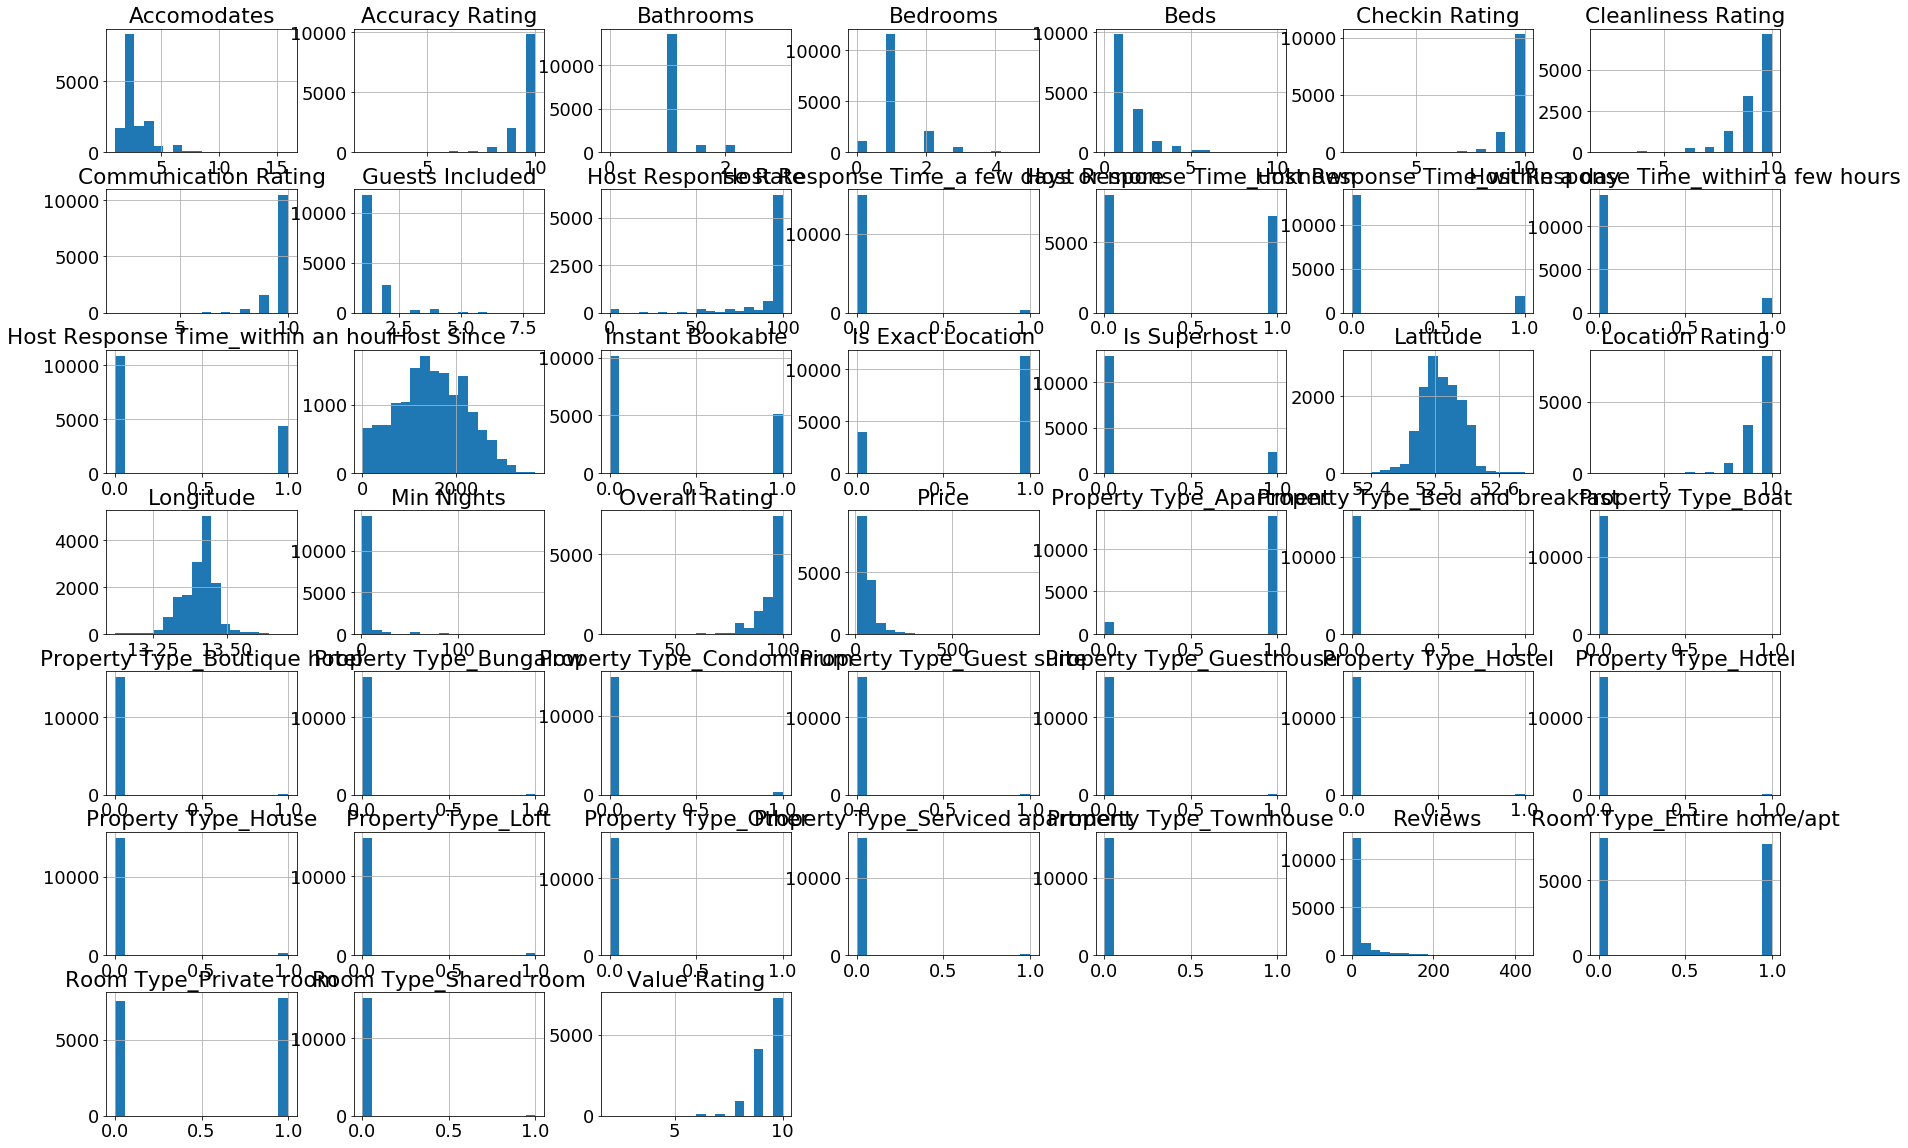

In [247]:
# Visualizing the distributions of the features in data_clean

data_clean.hist(figsize=(30,20),bins=18)

In [248]:
# Checking the proportion of missing values for the attributes where there are some left

features_missing = [feature for feature in data_clean.columns.tolist() if data_clean[feature].isna().sum()>0]
print(features_missing)

data_clean[features_missing].isna().sum()/data_clean.shape[0]

['Host Response Rate', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating']


Host Response Rate      0.462737
Overall Rating          0.184479
Accuracy Rating         0.185069
Cleanliness Rating      0.185003
Checkin Rating          0.185200
Communication Rating    0.185003
Location Rating         0.185069
Value Rating            0.185134
dtype: float64

We see that the proportion of missing values for these features is way too high to perform listwise selection. In order to preserve our data set, we have to impute them.

## Specific data preprocessing

We will begin by taking care of the remaining missing values. We will perform both univariate and multivariate feature imputation, making sure that the requirements for such methods are met.

For univariate imputation, we will use the following strategies:

- mean
- median
- most frequent value

For multivariate imputation, reserved for features that are Missing At Random (MAR), we will estimate the missing values of a feature by using the observed values of all the features.

All decision trees use np.float32 arrays internally, so we need to make sure all features can be represented by floats: all the remaining nominal categorical features will be encoded into one-hot encoders.

Additionally, to avoid any bias towards dominant classes, we will perform feature scaling using two approaches: min-max scaling and standardization.

## Dimension Reduction

### Feature Selection

In [210]:
from sklearn import tree
from sklearn import model_selection
from sklearn.pipeline import Pipeline

clf = tree.DecisionTreeRegressor().fit(X_train, y_train)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

def processSubset(feature_set):
    
    # Fit decision tree model on feature_set and calculate score
    score = -1 * model_selection.cross_val_score(clf,
                                                 X_train[list(feature_set)],
                                                 y_train.ravel(),
                                                 cv=kf_10,
                                                 scoring='neg_mean_squared_error').mean()

    return {"model": list(feature_set), "RSS": score}

#### Best Subset Selection

In [211]:
###

#### Forward Stepwise Selection

In [212]:
import itertools
import time
from tqdm import tqdm

def forward(features):
    
    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]

    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()     

    print("Processed", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [220]:
models_fwd = pd.DataFrame(columns=["model", "RSS"])

tic = time.time()
features = []

for i in tqdm(range(1, len(data.columns))):  # len()+1 ???
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")








  0%|          | 0/58 [00:00<?, ?it/s]






  2%|▏         | 1/58 [00:02<02:15,  2.38s/it]

Processed 58 models on 1 features in 2.375364065170288 seconds.
['Accomodates']









  3%|▎         | 2/58 [00:05<02:18,  2.47s/it]

Processed 57 models on 2 features in 2.669595241546631 seconds.
['Accomodates', 'Room Type_Entire home/apt']









  5%|▌         | 3/58 [00:08<02:30,  2.73s/it]

Processed 56 models on 3 features in 3.3339319229125977 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms']









  7%|▋         | 4/58 [00:12<02:45,  3.07s/it]

Processed 55 models on 4 features in 3.84582781791687 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown']









  9%|▊         | 5/58 [00:16<03:00,  3.41s/it]

Processed 54 models on 5 features in 4.206762313842773 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel']









 10%|█         | 6/58 [00:20<03:08,  3.63s/it]

Processed 53 models on 6 features in 4.150422096252441 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel']









 12%|█▏        | 7/58 [00:24<03:12,  3.78s/it]

Processed 52 models on 7 features in 4.105104923248291 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel']









 14%|█▍        | 8/58 [00:29<03:16,  3.93s/it]

Processed 51 models on 8 features in 4.291638135910034 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf']









 16%|█▌        | 9/58 [00:33<03:27,  4.24s/it]

Processed 50 models on 9 features in 4.9668638706207275 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other']









 17%|█▋        | 10/58 [00:39<03:43,  4.66s/it]

Processed 49 models on 10 features in 5.625663995742798 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat']









 19%|█▉        | 11/58 [00:45<03:49,  4.88s/it]

Processed 48 models on 11 features in 5.39293909072876 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf']









 21%|██        | 12/58 [00:50<03:49,  4.98s/it]

Processed 47 models on 12 features in 5.216602087020874 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse']









 22%|██▏       | 13/58 [00:55<03:44,  5.00s/it]

Processed 46 models on 13 features in 5.024316072463989 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow']









 24%|██▍       | 14/58 [01:00<03:42,  5.06s/it]

Processed 45 models on 14 features in 5.20753812789917 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast']









 26%|██▌       | 15/58 [01:05<03:40,  5.12s/it]

Processed 44 models on 15 features in 5.2563560009002686 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite']









 28%|██▊       | 16/58 [01:11<03:39,  5.22s/it]

Processed 43 models on 16 features in 5.445655107498169 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium']









 29%|██▉       | 17/58 [01:17<03:42,  5.42s/it]

Processed 42 models on 17 features in 5.899734020233154 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room']









 31%|███       | 18/58 [01:22<03:42,  5.55s/it]

Processed 41 models on 18 features in 5.842103958129883 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room']









 33%|███▎      | 19/58 [01:29<03:45,  5.77s/it]

Processed 40 models on 19 features in 6.291388750076294 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau']









 34%|███▍      | 20/58 [01:35<03:44,  5.91s/it]

Processed 39 models on 20 features in 6.22791862487793 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more']









 36%|███▌      | 21/58 [01:41<03:42,  6.03s/it]

Processed 38 models on 21 features in 6.289124011993408 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse']









 38%|███▊      | 22/58 [01:48<03:41,  6.16s/it]

Processed 37 models on 22 features in 6.452808141708374 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg']









 40%|███▉      | 23/58 [01:54<03:38,  6.23s/it]

Processed 36 models on 23 features in 6.412534952163696 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.']









 41%|████▏     | 24/58 [02:01<03:36,  6.37s/it]

Processed 35 models on 24 features in 6.689499139785767 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln']









 43%|████▎     | 25/58 [02:08<03:39,  6.65s/it]

Processed 34 models on 25 features in 7.298626184463501 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick']









 45%|████▍     | 26/58 [02:16<03:41,  6.92s/it]

Processed 33 models on 26 features in 7.556560277938843 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg']









 47%|████▋     | 27/58 [02:23<03:42,  7.17s/it]

Processed 32 models on 27 features in 7.725347995758057 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day']









 48%|████▊     | 28/58 [02:31<03:39,  7.31s/it]

Processed 31 models on 28 features in 7.660109043121338 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost']









 50%|█████     | 29/58 [02:39<03:37,  7.49s/it]

Processed 30 models on 29 features in 7.880695104598999 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House']









 52%|█████▏    | 30/58 [02:47<03:36,  7.72s/it]

Processed 29 models on 30 features in 8.277468919754028 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf']









 53%|█████▎    | 31/58 [02:55<03:29,  7.75s/it]

Processed 28 models on 31 features in 7.797546148300171 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow']









 55%|█████▌    | 32/58 [03:03<03:25,  7.90s/it]

Processed 27 models on 32 features in 8.263778924942017 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours']









 57%|█████▋    | 33/58 [03:13<03:27,  8.30s/it]

Processed 26 models on 33 features in 9.234086036682129 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour']









 59%|█████▊    | 34/58 [03:21<03:19,  8.33s/it]

Processed 25 models on 34 features in 8.396704196929932 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment']









 60%|██████    | 35/58 [03:29<03:11,  8.32s/it]

Processed 24 models on 35 features in 8.28662395477295 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy']









 62%|██████▏   | 36/58 [03:39<03:10,  8.66s/it]

Processed 23 models on 36 features in 9.44909119606018 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl']









 64%|██████▍   | 37/58 [03:48<03:08,  8.96s/it]

Processed 22 models on 37 features in 9.646456241607666 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable']









 66%|██████▌   | 38/58 [03:58<03:02,  9.15s/it]

Processed 21 models on 38 features in 9.586006164550781 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rat








 67%|██████▋   | 39/58 [04:08<02:57,  9.36s/it]

Processed 20 models on 39 features in 9.83624815940857 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 69%|██████▉   | 40/58 [04:18<02:53,  9.61s/it]

Processed 19 models on 40 features in 10.212163925170898 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Ra








 71%|███████   | 41/58 [04:28<02:43,  9.61s/it]

Processed 18 models on 41 features in 9.600568056106567 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rat








 72%|███████▏  | 42/58 [04:37<02:34,  9.64s/it]

Processed 17 models on 42 features in 9.70724606513977 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 74%|███████▍  | 43/58 [04:47<02:26,  9.75s/it]

Processed 16 models on 43 features in 9.985649108886719 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rat








 76%|███████▌  | 44/58 [04:56<02:13,  9.51s/it]

Processed 15 models on 44 features in 8.970907926559448 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rat








 78%|███████▊  | 45/58 [05:05<01:59,  9.21s/it]

Processed 14 models on 45 features in 8.507379055023193 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rat








 79%|███████▉  | 46/58 [05:14<01:51,  9.29s/it]

Processed 13 models on 46 features in 9.457130193710327 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rat








 81%|████████  | 47/58 [05:23<01:39,  9.08s/it]

Processed 12 models on 47 features in 8.591954708099365 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rat








 83%|████████▎ | 48/58 [05:31<01:27,  8.76s/it]

Processed 11 models on 48 features in 8.005939960479736 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rat








 84%|████████▍ | 49/58 [05:39<01:16,  8.46s/it]

Processed 10 models on 49 features in 7.74366021156311 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 86%|████████▌ | 50/58 [05:46<01:04,  8.11s/it]

Processed 9 models on 50 features in 7.2826828956604 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate',








 88%|████████▊ | 51/58 [05:53<00:54,  7.73s/it]

Processed 8 models on 51 features in 6.846930027008057 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 90%|████████▉ | 52/58 [06:00<00:44,  7.50s/it]

Processed 7 models on 52 features in 6.956053018569946 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 91%|█████████▏| 53/58 [06:07<00:36,  7.40s/it]

Processed 6 models on 53 features in 7.156906843185425 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 93%|█████████▎| 54/58 [06:13<00:27,  6.98s/it]

Processed 5 models on 54 features in 5.994368076324463 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 95%|█████████▍| 55/58 [06:18<00:19,  6.54s/it]

Processed 4 models on 55 features in 5.508554935455322 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 97%|█████████▋| 56/58 [06:23<00:11,  5.86s/it]

Processed 3 models on 56 features in 4.286189794540405 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








 98%|█████████▊| 57/58 [06:26<00:05,  5.06s/it]

Processed 2 models on 57 features in 3.188593864440918 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate








100%|██████████| 58/58 [06:28<00:00,  4.07s/it]

Processed 1 models on 58 features in 1.763382911682129 seconds.
['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Boutique hotel', 'Property Type_Hostel', 'Steglitz - Zehlendorf', 'Property Type_Other', 'Property Type_Boat', 'Reinickendorf', 'Property Type_Guesthouse', 'Property Type_Bungalow', 'Property Type_Bed and breakfast', 'Property Type_Guest suite', 'Property Type_Condominium', 'Room Type_Shared room', 'Room Type_Private room', 'Spandau', 'Host Response Time_a few days or more', 'Property Type_Townhouse', 'Lichtenberg', 'Charlottenburg-Wilm.', 'NeukÃ¶lln', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Host Response Time_within a day', 'Is Superhost', 'Property Type_House', 'Marzahn - Hellersdorf', 'Pankow', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Serviced apartment', 'Boy or Girl?_Boy', 'Boy or Girl?_Girl', 'Instant Bookable', 'Host Response Rate

We now have the best model $\mathcal{M}_k$ for each number of features $k$ and want to choose the best $\mathcal{M}_k$. The $\textbf{RSS}$ values obtained previously correspond to the prediction error on the test samples (thanks to our cross-validation approach). Therefore, we will choose the model with the lowest $\textbf{RSS}$.

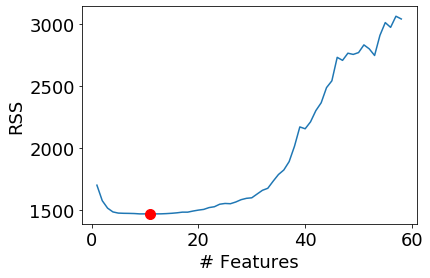

In [222]:
import matplotlib.pyplot as plt

plt.plot(models_fwd["RSS"])
plt.xlabel('# Features')
plt.ylabel('RSS')
plt.plot(models_fwd["RSS"].idxmin(), models_fwd["RSS"].min(), "or")

In [249]:
# Something seems wrong with the graph (minimum should be around 30 features)
# Obtain features of the best model according to the FSS

#### Backward Stepwise Selection

In [250]:
def backward(features):
        
    tic = time.time()    
        
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")

        
    # Return the best model, along with some other useful information about the model
    return best_model

In [251]:
models_bwd = pd.DataFrame(columns=["model", "RSS"], index = range(1, len(data.columns)))

tic = time.time()
features = data.columns

while(len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(features)
    features = models_bwd.loc[len(features)-1]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

KeyError: "['City', 'neighbourhood', 'Listing ID', 'Listing Name', 'Neighborhood Group', 'Business Travel Ready', 'First Review', 'Last Review', 'Postal Code', 'Room Type', 'Country', 'Host Response Time', 'Host ID', 'Host Name', 'Square Feet', 'Country Code', 'Property Type'] not in index"

### Principal Components Analysis (PCA)

## Decision Tree

In [223]:
import pandas as pd
import numpy as np
import copy
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import SGDRegressor
from sklearn import tree

In [224]:
data = pd.read_csv('../../data/train_airbnb_berlin_preprocessed.csv', delimiter = ';')

In [225]:
data = data.drop(['Host Name',  # we have gender info
                  'Postal Code',
                  'neighbourhood'], axis=1)  # removing neighborhood FOR NOW (check later)

In [226]:
# We encode 'Neighborhood Group' classes into a one hot encoder
encoder = pd.get_dummies(data['Neighborhood Group'], dtype = 'int64')
for feature in encoder.columns:
    data[feature] = encoder[feature]

del data['Neighborhood Group']

In [227]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=0)

In [228]:
features = [col for col in train_set.columns.tolist() if col != 'Price']

X_train, y_train = train_set[features], train_set['Price']

clf = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [229]:
from sklearn.metrics import mean_squared_error


X_test, y_test = test_set[features], test_set['Price']
y_predicted = clf.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_predicted))

57.07292638369519

In [232]:
from sklearn.model_selection import GridSearchCV

pgrid = {"max_depth": [1, 2, 3, 4, 5, 6, 7],
         "min_samples_split": [2, 3, 5, 10, 15, 20]}

grid_search = GridSearchCV(tree.DecisionTreeClassifier(),
                           param_grid=pgrid,
                           scoring='neg_mean_squared_error',
                           cv=10)
grid_search.fit(X_train, y_train)
# grid_search.best_estimator_.score(X_test, y_test)
y_predicted = grid_search.best_estimator_.predict(X_test)

print("MSE: ", mean_squared_error(y_test, y_predicted))
print("max_depth: ", grid_search.best_params_)

/Users/Paul/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


MSE:  1749.1234446627375
max_depth:  {'max_depth': 7, 'min_samples_split': 10}


/Users/Paul/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [233]:
y_predicted

array([30., 30., 30., ..., 50., 30., 30.])

In [234]:
y_test_array = np.array(y_test)

y_test_array

array([18., 39., 21., ..., 90., 60., 30.])

In [235]:
df = pd.DataFrame({'y_predicted': y_predicted, 'y_test': y_test_array})

In [236]:
df

,y_predicted,y_test
0,30.0,18.0
1,30.0,39.0
2,30.0,21.0
3,30.0,35.0
4,80.0,70.0
5,40.0,40.0
6,30.0,18.0
7,100.0,50.0
8,50.0,120.0
9,150.0,280.0


In [ ]:
# Below, some tests

                                          Price
Price                                  1.000000
Accomodates                            0.503195
Room Type_Entire home/apt              0.419790
Beds                                   0.418072
Bedrooms                               0.414246
Room Type_Private room                 0.410835
Guests Included                        0.356774
Bathrooms                              0.259733
Property Type_Loft                     0.161723
Property Type_Apartment                0.153003
Host Response Time_unknown             0.134629
Host Response Time_within an hour      0.103189
Property Type_Serviced apartment       0.100933
NeukÃ¶lln                              0.094428
Is Superhost                           0.073918
Reviews                                0.069833
Property Type_Hotel                    0.066789
Mitte                                  0.066628
Location Rating                        0.063794
Cleanliness Rating                     0

<BarContainer object of 59 artists>

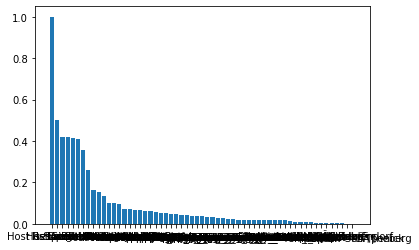

In [123]:
print(abs(train_set.corr()[['Price']]).sort_values(by='Price', ascending=False))

plt.bar(train_set.columns, abs(train_set.corr()['Price']).sort_values(ascending=False))

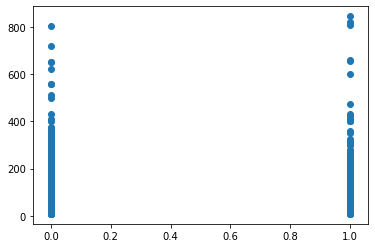

In [124]:
plt.scatter(train_set['Host Response Time_unknown'], train_set['Price'])

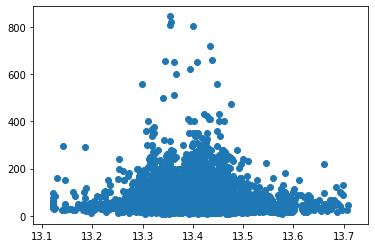

In [125]:
plt.scatter(train_set['Longitude'], train_set['Price'])

Index(['Host Since', 'Host Response Rate', 'Is Superhost', 'Latitude',
       'Longitude', 'Is Exact Location', 'Accomodates', 'Bathrooms',
       'Bedrooms', 'Beds', 'Guests Included', 'Min Nights', 'Reviews',
       'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Instant Bookable',
       'Host Response Time_a few days or more', 'Host Response Time_unknown',
       'Host Response Time_within a day',
       'Host Response Time_within a few hours',
       'Host Response Time_within an hour', 'Property Type_Apartment',
       'Property Type_Bed and breakfast', 'Property Type_Boat',
       'Property Type_Boutique hotel', 'Property Type_Bungalow',
       'Property Type_Condominium', 'Property Type_Guest suite',
       'Property Type_Guesthouse', 'Property Type_Hostel',
       'Property Type_Hotel', 'Property Type_House', 'Property Type_Loft',
       'Property Type_Other', 'Property Type_

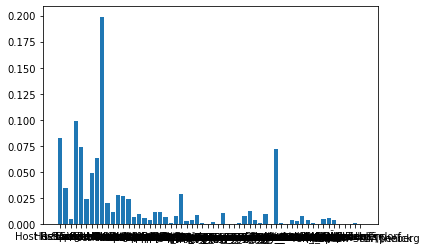

In [110]:
clf.feature_importances_
plt.bar(X_train.columns, clf.feature_importances_)
print(X_train.columns)